In [5]:
from main import Optimisation
%load_ext autoreload
%autoreload 2

In [7]:
import yfinance as yfin

prices = yfin.download(tickers=['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA'], period='1y')['Adj Close']
prices.head()

[*********************100%***********************]  5 of 5 completed


,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2020-10-30,108.164307,3036.149902,1621.010010,200.629013,388.040009
2020-11-02,108.074883,3004.479980,1626.030029,200.490295,400.510010
2020-11-03,109.734207,3048.409912,1650.209961,204.553009,423.899994
2020-11-04,114.215385,3241.159912,1749.130005,214.422470,420.980011
2020-11-05,118.269310,3322.000000,1763.369995,221.259705,438.089996


In [46]:
#opt = Optimisation(prices, objective_function = "sharpe", constraint = ["weights_constraint","industry_contraints"])
import numpy as np
industries = {'Tech': ['AAPL', 'GOOG'],
                'Car': ['MSFT', 'TSLA'],
                'Aloner': ['AMZN']}

tickers = prices.columns.tolist()
industryWeights = {'Tech': 0.4,
                    'Car': 0.4,
                    'Aloner': 0.2}

#opt.optimise(industries=industries, tickers=tickers, industryWeights=industryWeights, past_weights=[1/len(tickers)]*len(tickers))

     fun: -4.182120739309092
     jac: array([ 7.47369528e-02,  4.21222538e+00, -4.75645065e-05,  3.91781330e-04,
        4.00543213e-05])
 message: 'Optimization terminated successfully'
    nfev: 78
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([2.57249162e-13, 1.27119309e-14, 8.29587646e-01, 5.79881751e-13,
       9.94465456e-01])

In [108]:
from main import RollingOptimisation
import pandas as pd
import datetime as dt

prices = yfin.download(tickers=['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA'], period='1y', interval='1d')['Adj Close'].ffill()
rollopt = RollingOptimisation(prices, "sharpe", ["weights_constraint","industry_constraints"])

port, weights = rollopt.backtest(industries = industries, industryWeights = industryWeights)


[*********************100%***********************]  5 of 5 completed
[]


100%|██████████| 198/198 [00:05<00:00, 39.57it/s]


<AxesSubplot:>

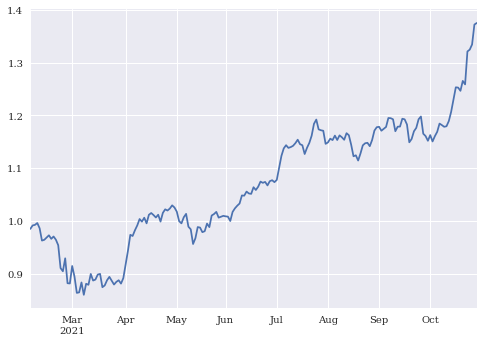

In [109]:
((weights * prices.iloc[63:, ].pct_change()).ffill().dropna().sum(axis=1)+1).cumprod().plot()

<AxesSubplot:>

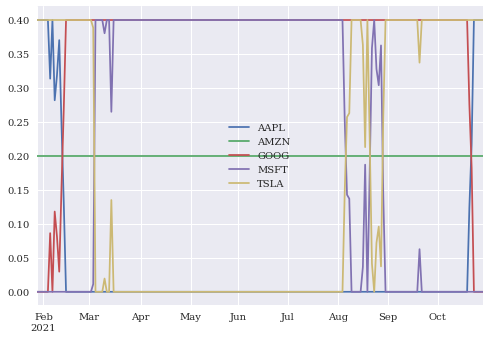

In [110]:
weights.plot()

In [111]:
weights.sum(axis=1)

2021-01-27    1.0
2021-01-28    1.0
2021-01-29    1.0
2021-02-01    1.0
2021-02-02    1.0
             ... 
2021-10-25    1.0
2021-10-26    1.0
2021-10-27    1.0
2021-10-28    1.0
2021-10-29    1.0
Length: 198, dtype: float64

In [112]:
for industry in industries:
    print(weights[industries[industry]])

            AAPL          GOOG
2021-01-27   0.4  0.000000e+00
2021-01-28   0.4  0.000000e+00
2021-01-29   0.4  4.171385e-13
2021-02-01   0.4  0.000000e+00
2021-02-02   0.4  5.123679e-14
...          ...           ...
2021-10-25   0.4  0.000000e+00
2021-10-26   0.4  4.717695e-08
2021-10-27   0.4  8.326673e-15
2021-10-28   0.4  5.634382e-15
2021-10-29   0.4  0.000000e+00

[198 rows x 2 columns]
                    MSFT  TSLA
2021-01-27  0.000000e+00   0.4
2021-01-28  0.000000e+00   0.4
2021-01-29  0.000000e+00   0.4
2021-02-01  2.083043e-10   0.4
2021-02-02  0.000000e+00   0.4
...                  ...   ...
2021-10-25  0.000000e+00   0.4
2021-10-26  6.159510e-09   0.4
2021-10-27  0.000000e+00   0.4
2021-10-28  0.000000e+00   0.4
2021-10-29  0.000000e+00   0.4

[198 rows x 2 columns]
            AMZN
2021-01-27   0.2
2021-01-28   0.2
2021-01-29   0.2
2021-02-01   0.2
2021-02-02   0.2
...          ...
2021-10-25   0.2
2021-10-26   0.2
2021-10-27   0.2
2021-10-28   0.2
2021-10-29   0.2

[19